# Machine Predictive Maintenance Data

------

## Part 3: Deep Learning

In the previous Jupyter Notebook, some machine learning models have been built by using RandomForestClassifier and GradientBoostingClassifier to perform prediction on machine failures. These models are able to achieve an accuracy of around 98.3% and an F1 score of around 71.5%.  

In this notebook, **deep learning** will be used to achieve a similar purpose, hopefully with a better accuracy and F1 score.  
- A simple Deep Neural Network (DNN) will be built first.
- The model will be tuned by adjusting the parameters such as layers, number of epochs, learning rates and so on. 

------

### 3a. Pre-modelling Data Processing

Firstly, the dataset is imported again, and some processings are performed so that the dataset can be fitted into the models later. 

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import joblib
import numpy as np  # Used in chart plotting during the learning rate tuning

In [2]:
# Import data
df_raw = pd.read_csv("dataset_raw.csv")

In [3]:
# Look at the top 10 rows of the data frame. 
df_raw.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


In [4]:
# Confirm the data types of the columns
df_raw.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

- Based on the data exploration in the previous notebook, the columns "**UDI**" and "**Product ID**" are both identifier that are **unique for every record**. Therefore, they are **dropped** from the data frame because they won't be helpful in the classification models.  
- As for the column "**Failure Type**", it is also **dropped** as it provides detailed information about the machine failures, which conflicted with our purpose of predicting the "Target" column.  

In [5]:
# Select only columns that we need. 
df_main = df_raw.drop(columns = ["UDI", "Product ID", "Failure Type"])

In [6]:
# Check the number of records for each Target value. 
df_main["Target"].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

Similar to the machine learning models in scikit-learn, the deep learning models in Tensorflow are unable to handle categorical variables directly. Here the corresponding column (in this case only "Type" columns) are converted into **dummy variables**.  
How **dummy variables** work is that, for example, for the "Type" column that has three unique values (L, M and H), it will create three new variables for each product type, with values of 0s and 1s (or True and False) to indicate whether that record falls under that product type. 

In [7]:
# For categorical variables, convert them to dummy variables
df_main = pd.get_dummies(df_main, columns = ["Type"])
display(df_main.head(10))

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,False,False,True
1,298.2,308.7,1408,46.3,3,0,False,True,False
2,298.1,308.5,1498,49.4,5,0,False,True,False
3,298.2,308.6,1433,39.5,7,0,False,True,False
4,298.2,308.7,1408,40.0,9,0,False,True,False
5,298.1,308.6,1425,41.9,11,0,False,False,True
6,298.1,308.6,1558,42.4,14,0,False,True,False
7,298.1,308.6,1527,40.2,16,0,False,True,False
8,298.3,308.7,1667,28.6,18,0,False,False,True
9,298.5,309.0,1741,28.0,21,0,False,False,True


Now that the processing has been done for the content of the dataset, two more things to do is:  
- Splitting the full dataset into **output variable** (the variable that will be predicted) & **input variables** (variables that will be used to predict the output variable).
- Splitting both input & output variables into **training set** (the set of data that will be used to train the model) & **test set** (the set of data that will be used to test the accuracy or quality of the trained model). This split are usually done at a fixed ratio, which in this case **6:4 split** will be used for the training:test sets of data. 

In [8]:
# Split into input & output variables 
X = df_main.drop(columns = "Target")
y = df_main["Target"]

# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=0)

------

### 3b. Deep Neural Network (DNN)

First, a simple model is created, and the training set of data is fitted into the model.  
After that, the fitted model is used to perform prediction on the test set of data, and then the accuracy is evaluated by comparing the predicted result with the actual result.  

At this stage, the model architecture used (number of layers and nodes) are arbitrary, and will be tuned later for a better performance. 

In [9]:
# Set a random seed first. 
tf.random.set_seed(42)

# Create, compile and fit the model. 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy", tf.keras.metrics.F1Score(threshold=0.5)]
)

history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.8995 - f1_score: 0.0980 - loss: 4.0498
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.9478 - f1_score: 0.1616 - loss: 0.3281 
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.9385 - f1_score: 0.0909 - loss: 0.6234 
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.9540 - f1_score: 0.1814 - loss: 0.2009 
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.9503 - f1_score: 0.1403 - loss: 0.3694 
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.9368 - f1_score: 0.0805 - loss: 0.7054 
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.9545 - f1_score: 0.1596 - loss: 0.3224 
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.9555 - f1_score: 0.2046 - loss: 0.1941 
Epoch 9/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.9580 - f1_score: 0.1651 - loss: 0.1741 
Epoch 10/200
188/188

The final training accuracy of the model is at around 97.1%, and the F1 score is at around 45.5%. Both of them are much lower than in the machine learning models in the previous notebook.  
The **model.summary()** function can be used to get a summary of the model architecture, including information about the layers, number of parameters and so on. 

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,541 (52.90 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,028 (35.27 KB)

By using the **model.evaluate()** function onto the test set of data, the performance of the model can be evaluated, based on the **loss function & metrics** specified during model compilation (in this case, **binary_crossentropy & accuracy** respectively).  
The **confusion matrix** is also created to better illustrate how the test set of data has been classified. 

In [11]:
# Evaluate the model to get loss function and accuracy. 
list_model_eval = model.evaluate(X_test, y_test, verbose = 0)  
    # Returns a list of at least 2 values, first one is loss and second onwards are the metrics used, in the same sequence. 
print("Loss (binary_crossentropy): " + str(list_model_eval[0]))
print("Accuracy: " + str(list_model_eval[1]))
print("F1 Score: " + str(list_model_eval[2]))

# Perform prediction on the test data by using the trained model. 
y_pred = model.predict(X_test, verbose = 0)
# Convert y_pred from Sigmoid (0 to 1) to binary (0 and 1)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]
# Create confusion matrix
display(pd.crosstab(y_test, y_pred))

Loss (binary_crossentropy): 0.07834362983703613
Accuracy: 0.9794999957084656
F1 Score: 0.5287355780601501


col_0,0,1
Target,,
0,3872,5
1,77,46


The accuracy obtained from the basic DNN model is at ~97.95%, and the F1 score obtained is at ~52.87%.  
Both of them are, again, lower than the machine learning models in the previous notebook. 

There are a few methods that can possibly improve the performance of the model. These are a few that can be attempted:  
- Adjusting the **number of epochs** used to train the model.  
- Using different **model optimizer** and **learning rates**.  
- Changing the **model architecture**, as in the layers used in the model and their respective parameters.  

------

### 3c. Adjusting the Number of Epochs. 

The model above was trained by using 200 epochs, which is just an arbitrary number. A better performance may be achievable with a lower or higher number of epochs.  
Here, a **chart** is plotted to illustrate the **F1 score and loss values** of the model in each epoch.  

In [14]:
# Code referenced from DeepLearning.io training material 
def plot_loss_acc(history):
    '''Plots the training and validation loss and F1 score from a history object'''
    # acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    f1 = history.history['f1_score']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']
    
    epochs = range(len(f1))
    
    # plt.plot(epochs, acc, 'bo', label='Training accuracy')
    # plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.plot(epochs, f1, 'bo', label='Training F1 Score')
    # plt.title('Training accuracy')
    plt.title('Training F1 Score')
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    # plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training loss')
    plt.legend()
    
    plt.show()

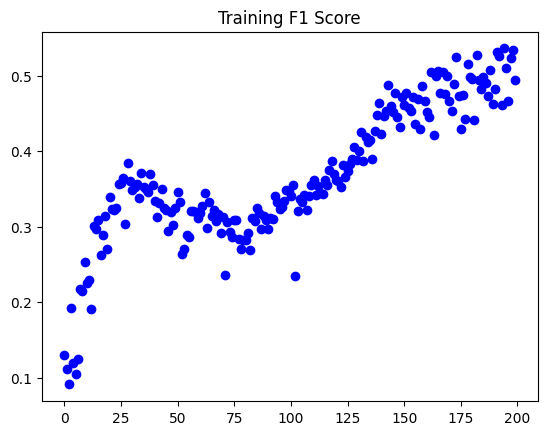

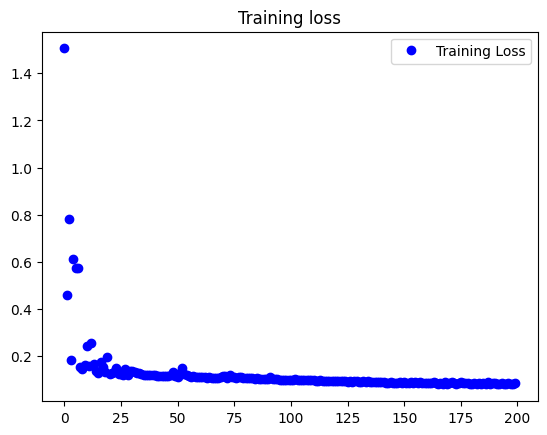

In [13]:
plot_loss_acc(history)

From the training F1 score plot, it can be seen that the F1 score is slowly increasing with the epochs, and it seems that it **could be better if more apochs were trained**.  
Therefore, the same model is trained again with **800 epochs** instead, and the same evaluations will be performed again. 

In [15]:
# Set a random seed first. 
tf.random.set_seed(42)

# Create, compile and fit the model. 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy", tf.keras.metrics.F1Score(threshold=0.5)]
)
history = model.fit(X_train, y_train, epochs=800)

Epoch 1/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - accuracy: 0.8437 - f1_score: 0.0669 - loss: 8.2930 
Epoch 2/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.9609 - f1_score: 0.1795 - loss: 0.1379 
Epoch 3/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.9549 - f1_score: 0.1156 - loss: 0.2114 
Epoch 4/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.9575 - f1_score: 0.2092 - loss: 0.1581 
Epoch 5/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.9531 - f1_score: 0.1638 - loss: 0.2062 
Epoch 6/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.9573 - f1_score: 0.2104 - loss: 0.1618 
Epoch 7/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.9643 - f1_score: 0.3094 - loss: 0.1399 
Epoch 8/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.9551 - f1_score: 0.2215 - loss: 0.1691 
Epoch 9/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.9539 - f1_score: 0.2069 - loss: 0.2244 
Epoch 10/800
188/18

In [16]:
# Evaluate the model to get loss function and accuracy. 
list_model_eval = model.evaluate(X_test, y_test, verbose = 0)  
    # Returns a list of at least 2 values, first one is loss and second onwards are the metrics used, in the same sequence. 
print("Loss (binary_crossentropy): " + str(list_model_eval[0]))
print("Accuracy: " + str(list_model_eval[1]))
print("F1 Score: " + str(list_model_eval[2]))

# Perform prediction on the test data by using the trained model. 
y_pred = model.predict(X_test, verbose = 0)
# Convert y_pred from Sigmoid (0 to 1) to binary (0 and 1)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]
# Create confusion matrix
display(pd.crosstab(y_test, y_pred))

Loss (binary_crossentropy): 0.08697294443845749
Accuracy: 0.9797499775886536
F1 Score: 0.5846153497695923


col_0,0,1
Target,,
0,3862,15
1,66,57


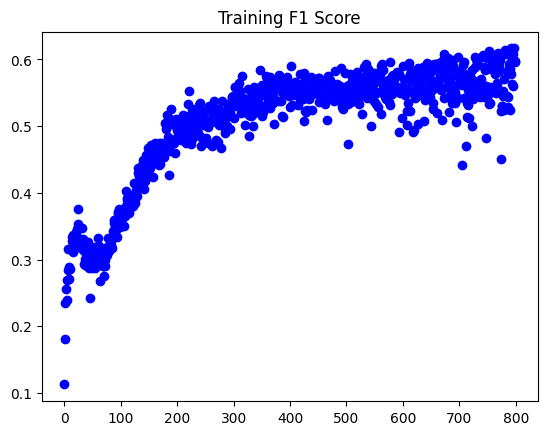

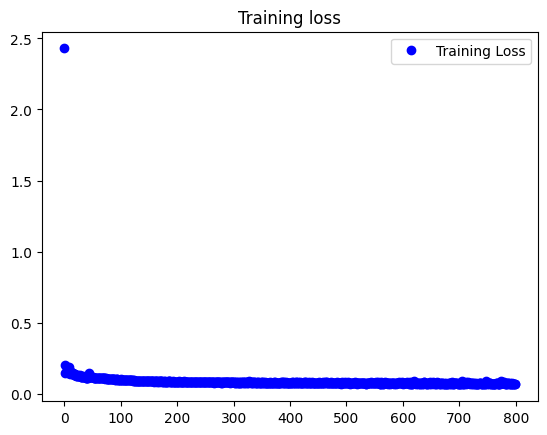

In [17]:
plot_loss_acc(history)

As there are now more epochs to train, the training took a longer time, and therefore a better performance was expected.  
The accuracy obtained here is around 97.97%, while the F1 score is around 58.46%. Both are slightly better than before, but not as good as the machine learning models yet.  
Also, it can be seen from the plot that the F1 score seems to be still on a slightly upward slope at the 800th epoch, hinting that the performance may be further improved with more epochs. However, this won't be done here as it will take up much more time and resources to train the model. 

------

### 3d. Using Different Model Architectures

Very often, a more complex model architecture may be required to solve a more complex problem, while a simple model architecture may perform better in the case of a simple problem.  
Here, a few approaches are taken to modify the model architecture, to find one that fits this use case better.  
- Increase the number of nodes in existing layers.
- Reduce the number of nodes in existing layers.
- Using less number of layers.
- Adding more Dense and/or Dropout layers.

After performing model training with these approaches separately, it is found that the performance of the model **improved the most by increasing the number of nodes in existing layers**. The model training process for this approach is as follows. 

In [18]:
# Set a random seed first. 
tf.random.set_seed(42)

# Create, compile and fit the model. 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy", tf.keras.metrics.F1Score(threshold=0.5)]
)
history = model.fit(X_train, y_train, epochs=800)

Epoch 1/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.9157 - f1_score: 0.0394 - loss: 4.2047   
Epoch 2/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.9439 - f1_score: 0.0980 - loss: 1.6693 
Epoch 3/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.9477 - f1_score: 0.1258 - loss: 0.6362 
Epoch 4/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.9419 - f1_score: 0.1288 - loss: 1.1423
Epoch 5/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.9591 - f1_score: 0.2046 - loss: 0.2575
Epoch 6/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.9601 - f1_score: 0.2481 - loss: 0.2073
Epoch 7/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.9595 - f1_score: 0.2317 - loss: 0.1848 
Epoch 8/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.9654 - f1_score: 0.3213 - loss: 0.1386 
Epoch 9/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.9616 - f1_score: 0.3139 - loss: 0.1642
Epoch 10/800
188/188 

In [19]:
# Evaluate the model to get loss function and accuracy. 
list_model_eval = model.evaluate(X_test, y_test, verbose = 0)  
    # Returns a list of at least 2 values, first one is loss and second onwards are the metrics used, in the same sequence. 
print("Loss (binary_crossentropy): " + str(list_model_eval[0]))
print("Accuracy: " + str(list_model_eval[1]))
print("F1 Score: " + str(list_model_eval[2]))

# Perform prediction on the test data by using the trained model. 
y_pred = model.predict(X_test, verbose = 0)
# Convert y_pred from Sigmoid (0 to 1) to binary (0 and 1)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]
# Create confusion matrix
display(pd.crosstab(y_test, y_pred))

Loss (binary_crossentropy): 0.07400111854076385
Accuracy: 0.9810000061988831
F1 Score: 0.6041666269302368


col_0,0,1
Target,,
0,3866,11
1,65,58


By increasing the number of nodes, the accuracy and F1 score increased to ~98.10% and 60.42%, possibly indicating that the model requires more nodes in existing layers to identify the patterns. 

Also, as a summary, here are the accuracy and F1 score of each model trained with different approaches mentioned above:  

| Models                                          | Accuracy | F1 Score |
|-------------------------------------------------|----------|----------|
| Existing model                                  | 97.97%   | 58.46%   |
| Increased number of nodes                       | 98.10%   | 60.42%   |
| Reduced number of nodes                         | 96.93%   | 0%       |
| Reduced number of layers                        | 97.50%   | 55.36%   |
| Increased number of layers (plus Dropout layer) | 98.10%   | 60.00%   |
  
In this section, the model architecture that performed the best is the one with increased number of nodes.  
A function is defined here to ease new model initialization in the following sections. 

In [28]:
# Use a function to return a new model with the best model architecture tested above. 
def best_model_architecture():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model 

------

### 3e. Model Optimizer and Learning Rate Tuning

Another thing that can be done to improve the model is to use a different model optimizer or learning rate to train the model across the epochs,  
Again, the models above were trained using an arbitrary model optimizer (Adam) and the default learning rate (0.001).  

Here, the **LearningRateScheduler** will be used to **identify an optimal learning rate** that can be used to optimize the model. Basically, what it will do is that during the model fitting process, the **learning rate will be adjusted on each epochs**. 

In [26]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 80)
)

In [29]:
# Set a random seed first. 
tf.random.set_seed(42)

# Create, compile and fit the model. 
model_tune = best_model_architecture()
model_tune.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy", tf.keras.metrics.F1Score(threshold=0.5)]
)
history = model_tune.fit(X_train, y_train, epochs=800, callbacks=[lr_schedule])

Epoch 1/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - accuracy: 0.9628 - f1_score: 0.0000e+00 - loss: 4.2278 - learning_rate: 1.0000e-08
Epoch 2/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.9628 - f1_score: 0.0000e+00 - loss: 4.2213 - learning_rate: 1.0292e-08
Epoch 3/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.9628 - f1_score: 0.0000e+00 - loss: 4.2144 - learning_rate: 1.0593e-08
Epoch 4/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.9628 - f1_score: 0.0000e+00 - loss: 4.2073 - learning_rate: 1.0902e-08
Epoch 5/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.9628 - f1_score: 0.0000e+00 - loss: 4.1999 - learning_rate: 1.1220e-08
Epoch 6/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.9628 - f1_score: 0.0000e+00 - loss: 4.1923 - learning_rate: 1.1548e-08
Epoch 7/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.9628 - f1_score: 0.0000e+00 - loss: 4.1844 - learning_rate: 1.1885e-08
Epoch 8/800
188/188 

Then, a chart is plotted to illustrate the **loss function value at each learning rate**.  

(1e-08, 100.0, 0.0, 1.0)

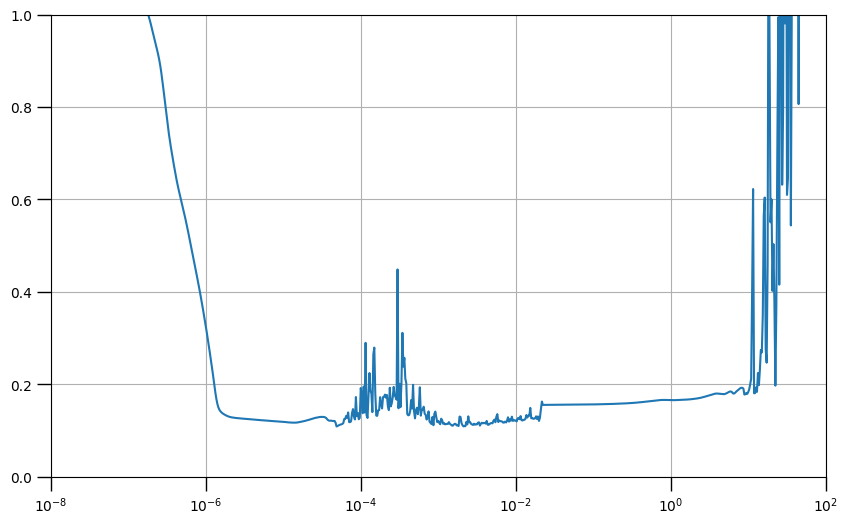

In [30]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(800) / 80))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params(axis='both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e2, 0, 1])

The optimal learning rate is identified by locating the **lowest smoother values** in the curve, and at the same time having a **downward slope**. Doing this may help the model **training converge to that loss value quicker**.  
Based on the plot above, one suitable learning rate value would be somewhere around **2e-3**. With this, the same model will be trained again with this learning rate. 

In [32]:
# Set a random seed first. 
tf.random.set_seed(42)

# Create, compile and fit the model. 
model = best_model_architecture()
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-3),
    metrics = ["accuracy", tf.keras.metrics.F1Score(threshold=0.5)]
)
history = model.fit(X_train, y_train, epochs=800)

Epoch 1/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.9118 - f1_score: 0.0996 - loss: 5.7663 
Epoch 2/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.9449 - f1_score: 0.1687 - loss: 0.3276 
Epoch 3/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.9459 - f1_score: 0.1416 - loss: 0.4764 
Epoch 4/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.9612 - f1_score: 0.2575 - loss: 0.1287 
Epoch 5/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.9569 - f1_score: 0.2131 - loss: 0.1440 
Epoch 6/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.9602 - f1_score: 0.2532 - loss: 0.1412 
Epoch 7/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.9365 - f1_score: 0.1287 - loss: 1.2065 
Epoch 8/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.9494 - f1_score: 0.2578 - loss: 0.5732 
Epoch 9/800
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.9598 - f1_score: 0.2543 - loss: 0.1408 
Epoch 10/800
188/18

In [33]:
# Evaluate the model to get loss function and accuracy. 
list_model_eval = model.evaluate(X_test, y_test, verbose = 0)  
    # Returns a list of at least 2 values, first one is loss and second onwards are the metrics used, in the same sequence. 
print("Loss (binary_crossentropy): " + str(list_model_eval[0]))
print("Accuracy: " + str(list_model_eval[1]))
print("F1 Score: " + str(list_model_eval[2]))

# Perform prediction on the test data by using the trained model. 
y_pred = model.predict(X_test, verbose = 0)
# Convert y_pred from Sigmoid (0 to 1) to binary (0 and 1)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]
# Create confusion matrix
display(pd.crosstab(y_test, y_pred))

Loss (binary_crossentropy): 0.07813923805952072
Accuracy: 0.9794999957084656
F1 Score: 0.5287355780601501


col_0,0,1
Target,,
0,3872,5
1,77,46


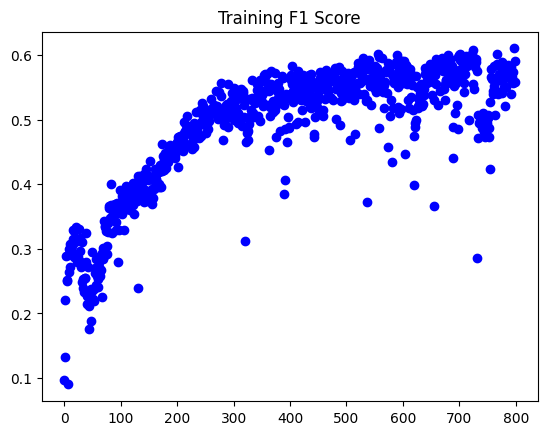

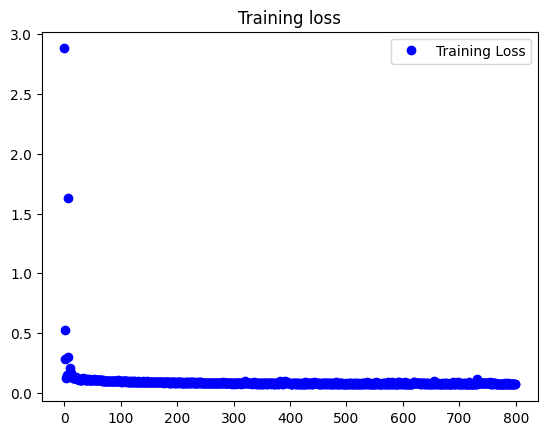

In [34]:
plot_loss_acc(history)

Prediction from the latest model gives an accuracy of ~97.95% and an F1 score of ~52.87%, which is unfortunately not as good as the previous model.  
Similar process is performed by using two other different optimizers (RMSProp and SGD), and the performances did not improve as well in both cases. 

------

### 3f. Saving Models into .h5 files. 

After getting a model that has a satisfying performance, **the model can be saved into a .h5** file.  
By doing this, the model can be imported and directly put into use in future, without the need to re-train it from scratch.  

Similar to the machine learning models in the previous notebook, it is safer to **save the input variable sequence** into a separate text file for reference, to make sure that the model can work properly in future. The step is not performed here as the column sequence is the same as the one used and saved in the previous notebook. 

In [47]:
# save model
model.save('myModel.h5')

With the save function above, the files are successfully saved into the local folder.  
To import the files in future, the load_model function can be used as follows. 

In [49]:
from tensorflow.keras.models import load_model

# load model
savedModel=load_model('myModel.h5')

In [50]:
savedModel.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                     │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,379 (5.39 KB)

 Trainable params: 1,377 (5.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

------

### Summary

The following table summarizes the performances of the **Deep Learning model** trained in this notebook, as well as the performances of **Machine Learning models** in the previous notebook.  

| Models               | Accuracy | F1 Score |
|----------------------|----------|----------|
| Random Forest        | 98.28%   | 65.33%   |
| Gradient Boosting    | 98.33%   | 71.49%   |
| Deep Learning Model  | 98.10%   | 60.42%   |

To summarize, in this notebook, Neural Network is used to perform classification for the machine failure prediction dataset.  

- Although various approaches have been taken to optimize the model, the **final accuracy** is **slightly lower**, but almost similar, to the accuracy obtained from the **machine learning models** in the previous notebook.
- The **F1 score** obtained from the deep learning models are **much lower than the machine learning models**. 
- On top of that, **more resources** (processing power & time taken) are required to **train the neural network models** compared to the machine learning models.  

Therefore, for this machine failure prediction problem, **machine learning model is a more suitable choice** to be used for the failure prediction.  
Neural Network models can also be used for this problem, but its performance may be better in performing a more complex task, such as image classification or natural language processing. 